In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit

In [24]:
#Load in training data
df = pd.read_csv('./data/movementSensorData.csv')

### Exploring the data

In [25]:
df.head()

,id,activity,time_s,lw_x,lw_y,lw_z
0,63804,2,638.05,-0.188,-0.941,-0.316
1,63805,2,638.06,-0.121,-0.879,-0.320
2,63806,2,638.07,-0.070,-0.852,-0.305
3,63807,2,638.08,-0.023,-0.879,-0.277
4,63808,2,638.09,0.008,-0.941,-0.242


In [26]:
df.shape

(507827, 6)

In [27]:
df.describe()

,id,activity,time_s,lw_x,lw_y,lw_z
count,507827.000000,507827.000000,507827.000000,507827.000000,507827.000000,507827.000000
mean,167785.101830,4.191809,1677.861018,-0.211302,-0.021941,-0.477602
std,63888.316941,8.785676,638.883169,0.524070,0.727952,0.443465
min,63804.000000,1.000000,638.050000,-5.289000,-5.305000,-6.875000
25%,89195.000000,2.000000,891.960000,-0.734000,-0.219000,-0.828000
50%,188844.000000,4.000000,1888.450000,-0.098000,0.184000,-0.570000
75%,220583.000000,4.000000,2205.840000,0.176000,0.426000,-0.148000
max,252322.000000,77.000000,2523.230000,5.516000,4.418000,4.551000


In [28]:
df.isnull().sum()

id          0
activity    0
time_s      0
lw_x        0
lw_y        0
lw_z        0
dtype: int64

### Preprocessing

In [31]:
scaler=StandardScaler()
scaler.fit(df)
scaler_train = scaler.transform(df)

In [41]:
X = df.iloc[:, 2:5] #time and data minus activity
y = df.iloc[:, 1] #just activity

In [44]:
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=48,
    max_train_size=10000,
    test_size=1000,
)

all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]

In [34]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
#X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.5, random_state=101)
#look into https://scikit-learn.org/stable/auto_examples/applications/plot_time_series_lagged_features.html#sphx-glr-auto-examples-applications-plot-time-series-lagged-features-py

### Playing with Models

In [35]:
xg_reg = xgb.XGBRegressor(colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=1000, verbosity=3)

In [36]:
xg_reg.fit(X_train, y_train)

[18:22:48] ======== Monitor (0): HostSketchContainer ========
[18:22:48] AllReduce: 0.001224s, 1 calls @ 1224us

[18:22:48] MakeCuts: 0.001291s, 1 calls @ 1291us

[18:22:48] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
[18:22:52] ======== Monitor (0): Learner ========
[18:22:52] Configure: 0.000366s, 1 calls @ 366us

[18:22:52] EvalOneIter: 0.006554s, 1000 calls @ 6554us

[18:22:52] GetGradient: 0.1061s, 1000 calls @ 106100us

[18:22:52] PredictRaw: 0.001418s, 1000 calls @ 1418us

[18:22:52] UpdateOneIter: 2.97698s, 1000 calls @ 2976976us

[18:22:52] ======== Monitor (0): GBTree ========
[18:22:52] BoostNewTrees: 2.86233s, 1000 calls @ 2862326us

[18:22:52] CommitModel: 0.000343s, 1000 calls @ 343us

[18:22:52] ======== Monitor (0): HistUpdater ========
[18:22:52] BuildHistogram: 0.30886s, 5000 calls @ 308860us

[18:22:52] EvaluateSplits: 0.100422s, 6000 calls @ 1004

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Evaluation

In [37]:
y_pred = xg_reg.predict(X_test)

[18:22:56] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0


In [38]:
metrics.mean_absolute_error(y_test, y_pred)

1.3524579762322892

In [39]:
metrics.r2_score(y_test, y_pred)

0.5359121332805741

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

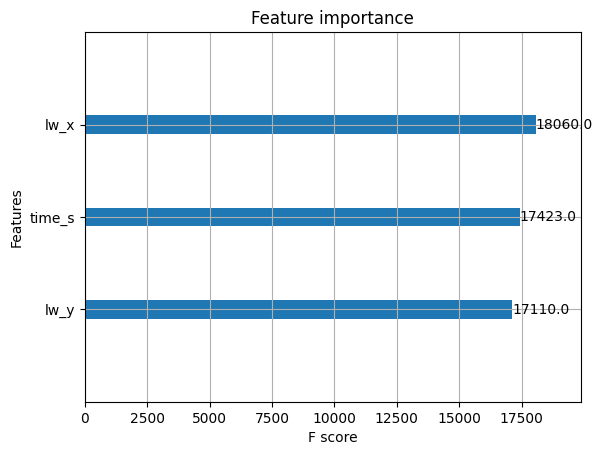

In [40]:
xgb.plot_importance(xg_reg)